# Demand Forecasting using LSTM

What we need to predict is the electricity consuumption of a household with a one-minute sampling rate based on the past 4 years of consumption

This is from a Kaggle competition.

The data can be downloaded from here: https://www.kaggle.com/uciml/electric-power-consumption-data-set

## Read in the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from time import time

# Suppress Scientific notations and display float up to 2 decimals
np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:.2f}'.format

os.chdir(r'C:\Users\amitr\Desktop\Machine Learning\Data')
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('household_power_consumption.txt', delimiter=';')
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.00
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.00
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.00
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.00
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.00


In [3]:
# Check the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
Date                     object
Time                     object
Global_active_power      object
Global_reactive_power    object
Voltage                  object
Global_intensity         object
Sub_metering_1           object
Sub_metering_2           object
Sub_metering_3           float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


## Prepare the data

For this problem we will do a Univariate time series modeling using only the Global_active_power as the variable.
So let us keep only the columns that we need, and also convert the Global_active_power to numeric

1) Create a Date-Time column
<br>2) Keep only the columns we need
<br>3) Address missing values
<br>4) Convert all the data to float
<br>5) Create columns for Year, Quarter, Month, Day, Weekday to observe the trends

In [4]:
# Create a new column for Date-time
df['Datetime'] = pd.to_datetime(df.Date + ' ' + df.Time)

In [5]:
# Keep only the columns we need
df = df.loc[:,['Datetime','Global_active_power']]
df.head()

,Datetime,Global_active_power
0,2006-12-16 17:24:00,4.216
1,2006-12-16 17:25:00,5.360
2,2006-12-16 17:26:00,5.374
3,2006-12-16 17:27:00,5.388
4,2006-12-16 17:28:00,3.666


In [6]:
# The missing values are denoted by "?". Let us check how many missing values are there in each column
df.apply(lambda x : sum(x=="?"))

Datetime                   0
Global_active_power    25979
dtype: int64

In [7]:
# Fill all the missing values with the data from the previous row (previous minute)
df.replace('?', np.nan, inplace=True)
df.fillna(method='ffill', inplace=True)
df.apply(lambda x : sum(x=='?'))

Datetime               0
Global_active_power    0
dtype: int64

In [8]:
# Convert to numeric
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'])

# Ensure the data is sorted
df.sort_values('Datetime', inplace=True, ascending=True)

# Set the Datetime column as the index
df.set_index('Datetime', inplace=True)

df.head()

,Global_active_power
Datetime,
2006-12-16 17:24:00,4.22
2006-12-16 17:25:00,5.36
2006-12-16 17:26:00,5.37
2006-12-16 17:27:00,5.39
2006-12-16 17:28:00,3.67


In [9]:
# Save the processed file for future use
df.to_csv('household_power_consumption_final.csv')

## Plotting the time series

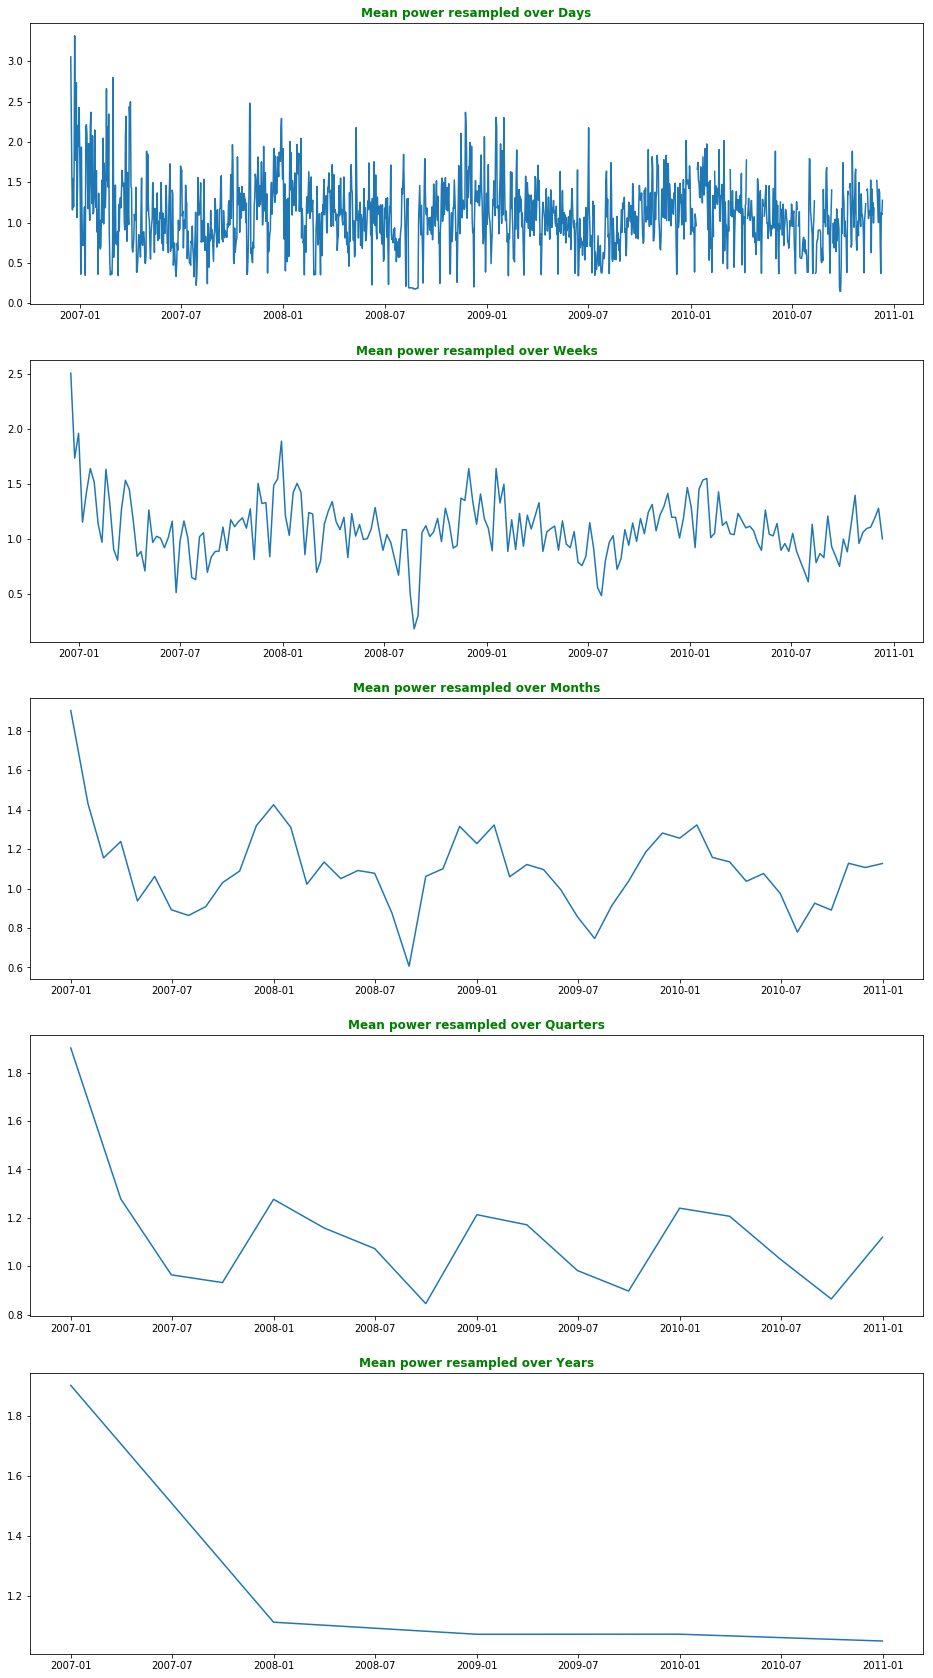

In [10]:
# Plot the average Daily consumption on different time scales
fig, ax = plt.subplots(5, figsize=(16,30))

# Daily
ax[0].plot(df['Global_active_power'].resample('D').mean())
ax[0].set_title('Mean power resampled over Days',fontweight="bold", color='g')

# Weekly
ax[1].plot(df['Global_active_power'].resample('W').mean())
ax[1].set_title('Mean power resampled over Weeks',fontweight="bold", color='g')

# Monthly
ax[2].plot(df['Global_active_power'].resample('M').mean())
ax[2].set_title('Mean power resampled over Months',fontweight="bold", color='g')

# Quarterly
ax[3].plot(df['Global_active_power'].resample('Q').mean())
ax[3].set_title('Mean power resampled over Quarters',fontweight="bold", color='g')

# Yearly
ax[4].plot(df['Global_active_power'].resample('Y').mean())
ax[4].set_title('Mean power resampled over Years',fontweight="bold", color='g')

plt.show()

## Check if the series is Stationary

We will use the Dickey-Fuller test to check this

H0: The time-series has a unit root, i.e. it is NOT stationary
<br>H1: The time series is stationary

In [79]:
# Aggregate the data at a day level
daily_data = df.resample('D').mean()

# Check if there are any NaNs in the daily data
np.sum(daily_data.isna())

# Replace the NaNs by the previous day's value
daily_data.fillna(method='ffill', inplace=True)

daily_data.head()

,Global_active_power
Datetime,
2006-12-16,3.05
2006-12-17,2.35
2006-12-18,1.53
2006-12-19,1.16
2006-12-20,1.55


In [80]:
# Define a function to check the Stationarity

from statsmodels.tsa.stattools import adfuller

def Stationarity_Check(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags used','#Observations'])
    print("\nResults of the Augmented Dickey Fuller Test : \n")
    print (dfoutput)

In [81]:
# Perform the DF test to verify the stationarity

Stationarity_Check(daily_data.Global_active_power.values)


Results of the Augmented Dickey Fuller Test : 

Test Statistic     -8.29
p-value             0.00
#Lags used          9.00
#Observations    1447.00
dtype: float64


From the p-value we can reject the Null hypothesis and conclude that the data is Stationary

## Time series modeling using LSTM

### Prepare the data for modeling

In [12]:
data = df['Global_active_power'].values
data = data.reshape((-1,1))
data.shape

(2075259, 1)

In [13]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(data)

In [14]:
# Split into training/test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size,], data[train_size:,]

# Prepare the data in a format required for LSTM (samples, timesteps, features)

def Create_Dataset(df, lookback=1):
    X, Y = [], []
    for i in range(len(df) - lookback - 1):
        X.append(df[i:(i+lookback), 0])
        Y.append(df[i + lookback,0])
    return np.array(X), np.array(Y)

lookback = 30
X_train, Y_train = Create_Dataset(train, lookback)
X_test, Y_test   = Create_Dataset(test, lookback)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test  = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [25]:
# Print the data
print("X_train : \n")
print(X_train[:2])

print("\n\nY_train : \n")
print(Y_train[:2])


X_train : 

[[[0.37479631 0.47836321 0.47963064 0.48089806 0.32500453 0.31178707
   0.32826362 0.32808256 0.32518559 0.3246424  0.39579938 0.48307079
   0.46605106 0.4700344  0.36013036 0.29947492 0.28915445 0.30363933
   0.28879232 0.33061742 0.5267065  0.69074778 0.62918704 0.46152453
   0.39815318 0.28716277 0.28607641 0.28535216 0.28806808 0.28082564]]

 [[0.47836321 0.47963064 0.48089806 0.32500453 0.31178707 0.32826362
   0.32808256 0.32518559 0.3246424  0.39579938 0.48307079 0.46605106
   0.4700344  0.36013036 0.29947492 0.28915445 0.30363933 0.28879232
   0.33061742 0.5267065  0.69074778 0.62918704 0.46152453 0.39815318
   0.28716277 0.28607641 0.28535216 0.28806808 0.28082564 0.23936267]]]


Y_train : 

[[2.72  3.758 4.342 ... 1.922 1.912 1.91 ]]


In [26]:
# Check the shapes of the data for modeling
print("X_train : ", X_train.shape)
print("Y_train : ", Y_train.shape)
print("\nX_test : ", X_test.shape)
print("Y_test : ", Y_test.shape)

X_train :  (1660176, 1, 30)
Y_train :  (1, 1660176)

X_test :  (415021, 1, 30)
Y_test :  (1, 415021)


### Build the LSTM model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               52400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 52,501
Trainable params: 52,501
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [16]:
history = model.fit(X_train, Y_train, 
                    epochs=20, 
                    batch_size=70,
                    validation_data=(X_test, Y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
                    verbose=1,
                    shuffle=False)

Train on 1660176 samples, validate on 415021 samples
Epoch 1/20
1660176/1660176 [==============================] - 72s 44us/sample - loss: 7.6375e-04 - val_loss: 4.3379e-04
Epoch 2/20
1660176/1660176 [==============================] - 69s 41us/sample - loss: 6.6012e-04 - val_loss: 4.0127e-04
Epoch 3/20
1660176/1660176 [==============================] - 69s 42us/sample - loss: 6.4885e-04 - val_loss: 3.8866e-04
Epoch 4/20
1660176/1660176 [==============================] - 69s 42us/sample - loss: 6.4229e-04 - val_loss: 3.8389e-04
Epoch 5/20
1660176/1660176 [==============================] - 68s 41us/sample - loss: 6.3850e-04 - val_loss: 3.8481e-04
Epoch 6/20
1660176/1660176 [==============================] - 72s 43us/sample - loss: 6.3363e-04 - val_loss: 3.8370e-04
Epoch 7/20
1660176/1660176 [==============================] - 69s 41us/sample - loss: 6.3172e-04 - val_loss: 3.8222e-04
Epoch 8/20
1660176/1660176 [==============================] - 68s 41us/sample - loss: 6.3117e-04 - val_loss

### Make the predictions and convert back to the original scale

In [17]:
# Make the predictions
train_predict = model.predict(X_train)
test_predict  = model.predict(X_test)

# Invert the predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])

test_predict  = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])


### Check the RMSE scores

In [18]:
from sklearn.metrics import mean_squared_error

print ("Train MAE : ", mean_squared_error(Y_train[0], train_predict[:,0]))
print ("Train RMSE : ", np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))

print ("\nTest MAE : ", mean_squared_error(Y_test[0], test_predict[:,0]))
print ("Test RMSE : ", np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train MAE :  0.07079281774905966
Train RMSE :  0.26606919729472567

Test MAE :  0.04702939069887034
Test RMSE :  0.21686260788543132


### Plot the model losses

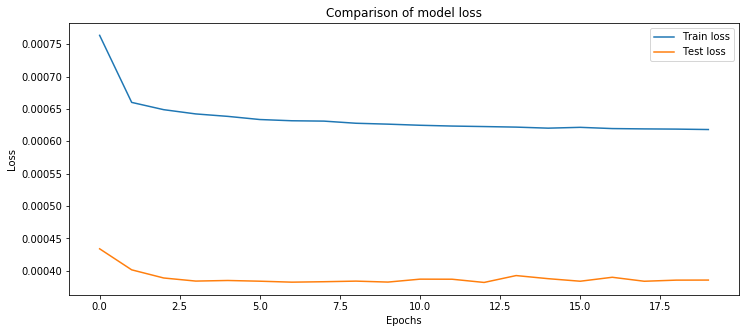

In [19]:
plt.figure(figsize=(12,5))
plt.title('Comparison of model loss')
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

### Plot the predicted vs actual values

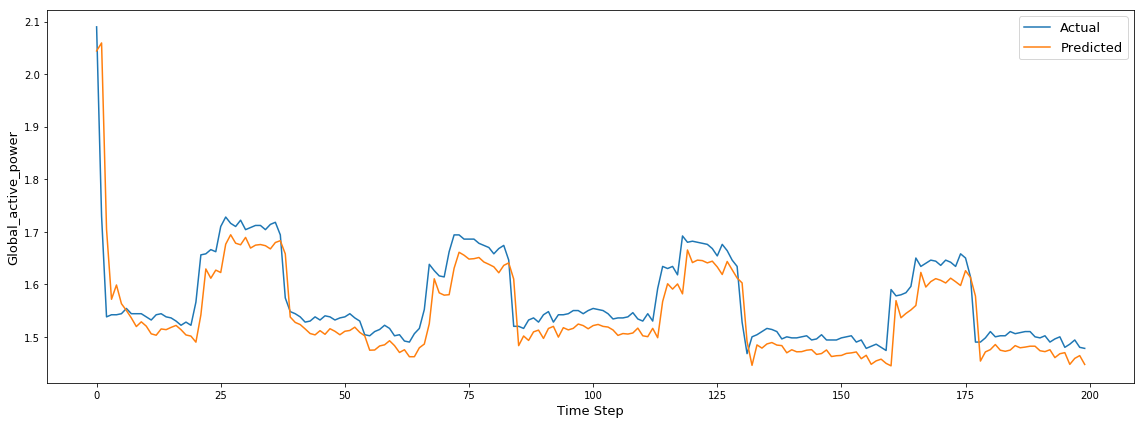

In [21]:
actual = Y_test[0][:200]
predicted = test_predict[:,0][:200]

plt.figure(figsize=(16,6))
plt.plot(actual, label='Actual')
plt.plot(predicted, label='Predicted')
plt.ylabel('Global_active_power', size=13)
plt.xlabel('Time Step', size=13)
plt.tight_layout()
plt.legend(fontsize=13)
plt.show()